In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from PIL import Image, UnidentifiedImageError, ImageEnhance, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = False
from pathlib import Path
from collections import Counter, defaultdict
import hashlib
import shutil
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Model: EfficientNetB0

In [29]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 16839 files belonging to 22 classes.
Found 3598 files belonging to 22 classes.
Found 3634 files belonging to 22 classes.


In [30]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']
22


In [31]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [38]:
pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,
    input_shape=(224,224,3),
    classes=num_classes
)   
pretrained_model.load_weights('efficientnetb0_notop.h5')
pretrained_model.trainable = False  # Freeze layer-layer EfficientNetB0-nya

In [39]:
model = models.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

In [40]:
pretrained_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_21        │ (None, 224, 224,  │          0 │ input_layer_11[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_11    │ (None, 224, 224,  │          7 │ rescaling_21[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization_11… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │        11,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,716,729 (17.99 MB)

 Trainable params: 667,158 (2.55 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [42]:
train_labels_list = []

for _, labels in train_ds.unbatch():
    train_labels_list.append(int(labels.numpy()))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=train_labels_list
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.6325694966190833), 1: np.float64(2.7934638354346384), 2: np.float64(0.7998005129666572), 3: np.float64(0.7939928328932478), 4: np.float64(0.6508580705009277), 5: np.float64(0.42194547459156057), 6: np.float64(0.746740576496674), 7: np.float64(1.079561482241313), 8: np.float64(0.9166575939031029), 9: np.float64(0.9838163122224819), 10: np.float64(3.865702479338843), 11: np.float64(1.62507237984945), 12: np.float64(5.390204865556978), 13: np.float64(1.1721425588194347), 14: np.float64(1.394187779433681), 15: np.float64(1.0660293745251963), 16: np.float64(1.194085945255992), 17: np.float64(2.3623737373737375), 18: np.float64(0.8514005460612802), 19: np.float64(2.1440030557677616), 20: np.float64(0.47689039932030586), 21: np.float64(1.4174242424242425)}


In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [45]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 200s 354ms/step - accuracy: 0.5735 - loss: 1.3166 - val_accuracy: 0.7410 - val_loss: 0.7916
Epoch 2/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 201s 375ms/step - accuracy: 0.7370 - loss: 0.6761 - val_accuracy: 0.7838 - val_loss: 0.6225
Epoch 3/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 203s 378ms/step - accuracy: 0.7733 - loss: 0.5593 - val_accuracy: 0.8082 - val_loss: 0.5530
Epoch 4/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 192s 359ms/step - accuracy: 0.7956 - loss: 0.4959 - val_accuracy: 0.8146 - val_loss: 0.5132
Epoch 5/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 208s 388ms/step - accuracy: 0.8133 - loss: 0.4537 - val_accuracy: 0.8185 - val_loss: 0.5008
Epoch 6/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 205s 382ms/step - accuracy: 0.8258 - loss: 0.4200 - val_accuracy: 0.8299 - val_loss: 0.4737
Epoch 7/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 207s 385ms/step - accuracy: 0.8372 - loss: 0.3900 - val_accuracy: 0.8207 - val_loss: 0.4737
Epoch 8/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 206s 383ms/step - accuracy: 0.8422 -

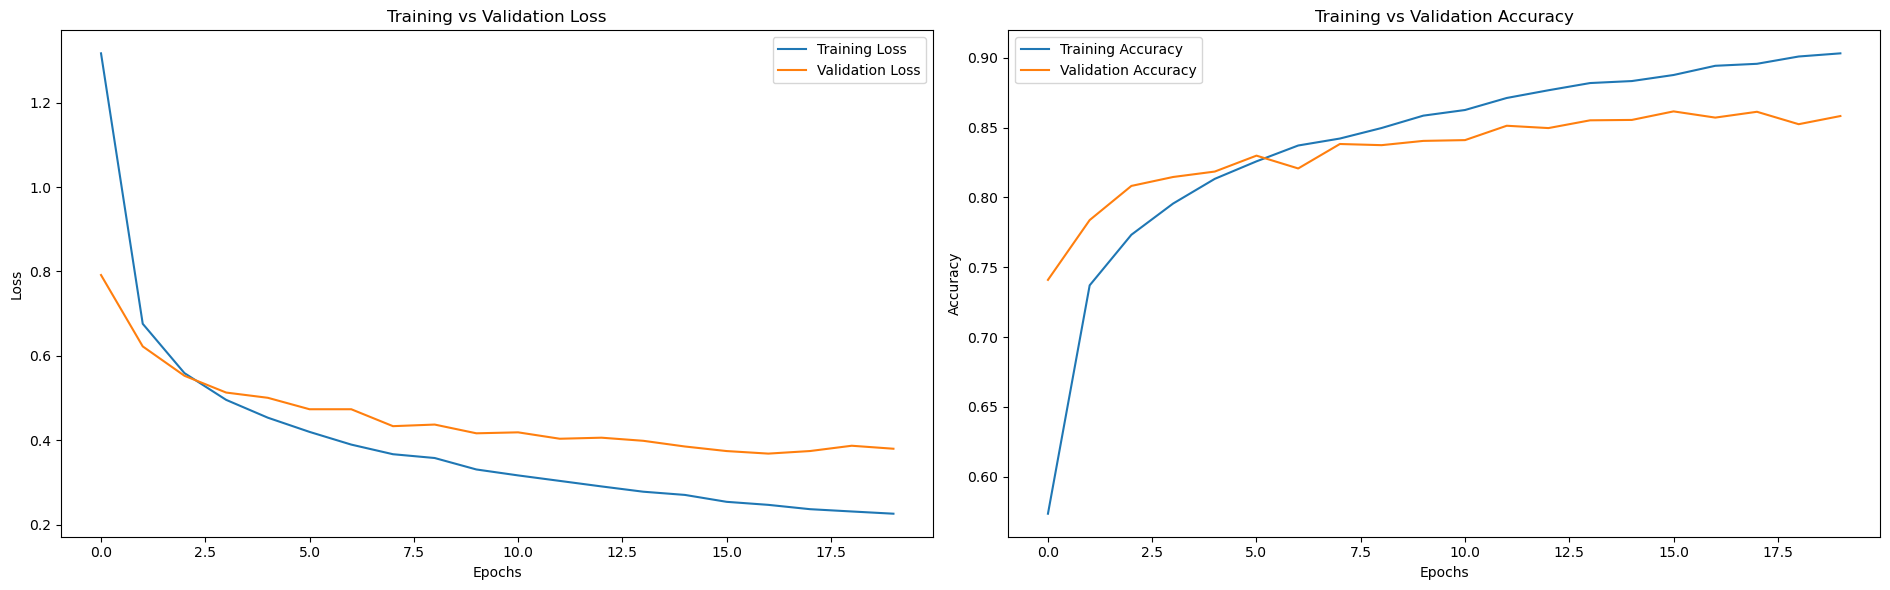

In [46]:
plt.figure(figsize=(19, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

114/114 ━━━━━━━━━━━━━━━━━━━━ 38s 334ms/step - accuracy: 0.8577 - loss: 0.3838
Test Accuracy: 0.8577325344085693
Test Loss: 0.3838418424129486


In [48]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [49]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                           precision    recall  f1-score   support

       Cashew anthracnose       0.94      0.86      0.90       260
           Cashew gumosis       1.00      1.00      1.00        60
           Cashew healthy       0.96      0.96      0.96       206
        Cashew leaf miner       0.90      0.96      0.93       208
          Cashew red rust       0.98      0.98      0.98       253
 Cassava bacterial blight       0.89      0.84      0.87       390
       Cassava brown spot       0.85      0.88      0.87       221
       Cassava green mite       0.86      0.94      0.90       153
          Cassava healthy       0.96      0.96      0.96       180
           Cassava mosaic       0.94      0.96      0.95       168
      Maize fall armyworm       0.89      0.95      0.92        44
         Maize grasshoper       1.00      0.97      0.99       102
            Maize healthy       0.81      0.94      0.87        31
        Maize leaf beetle       0.94  

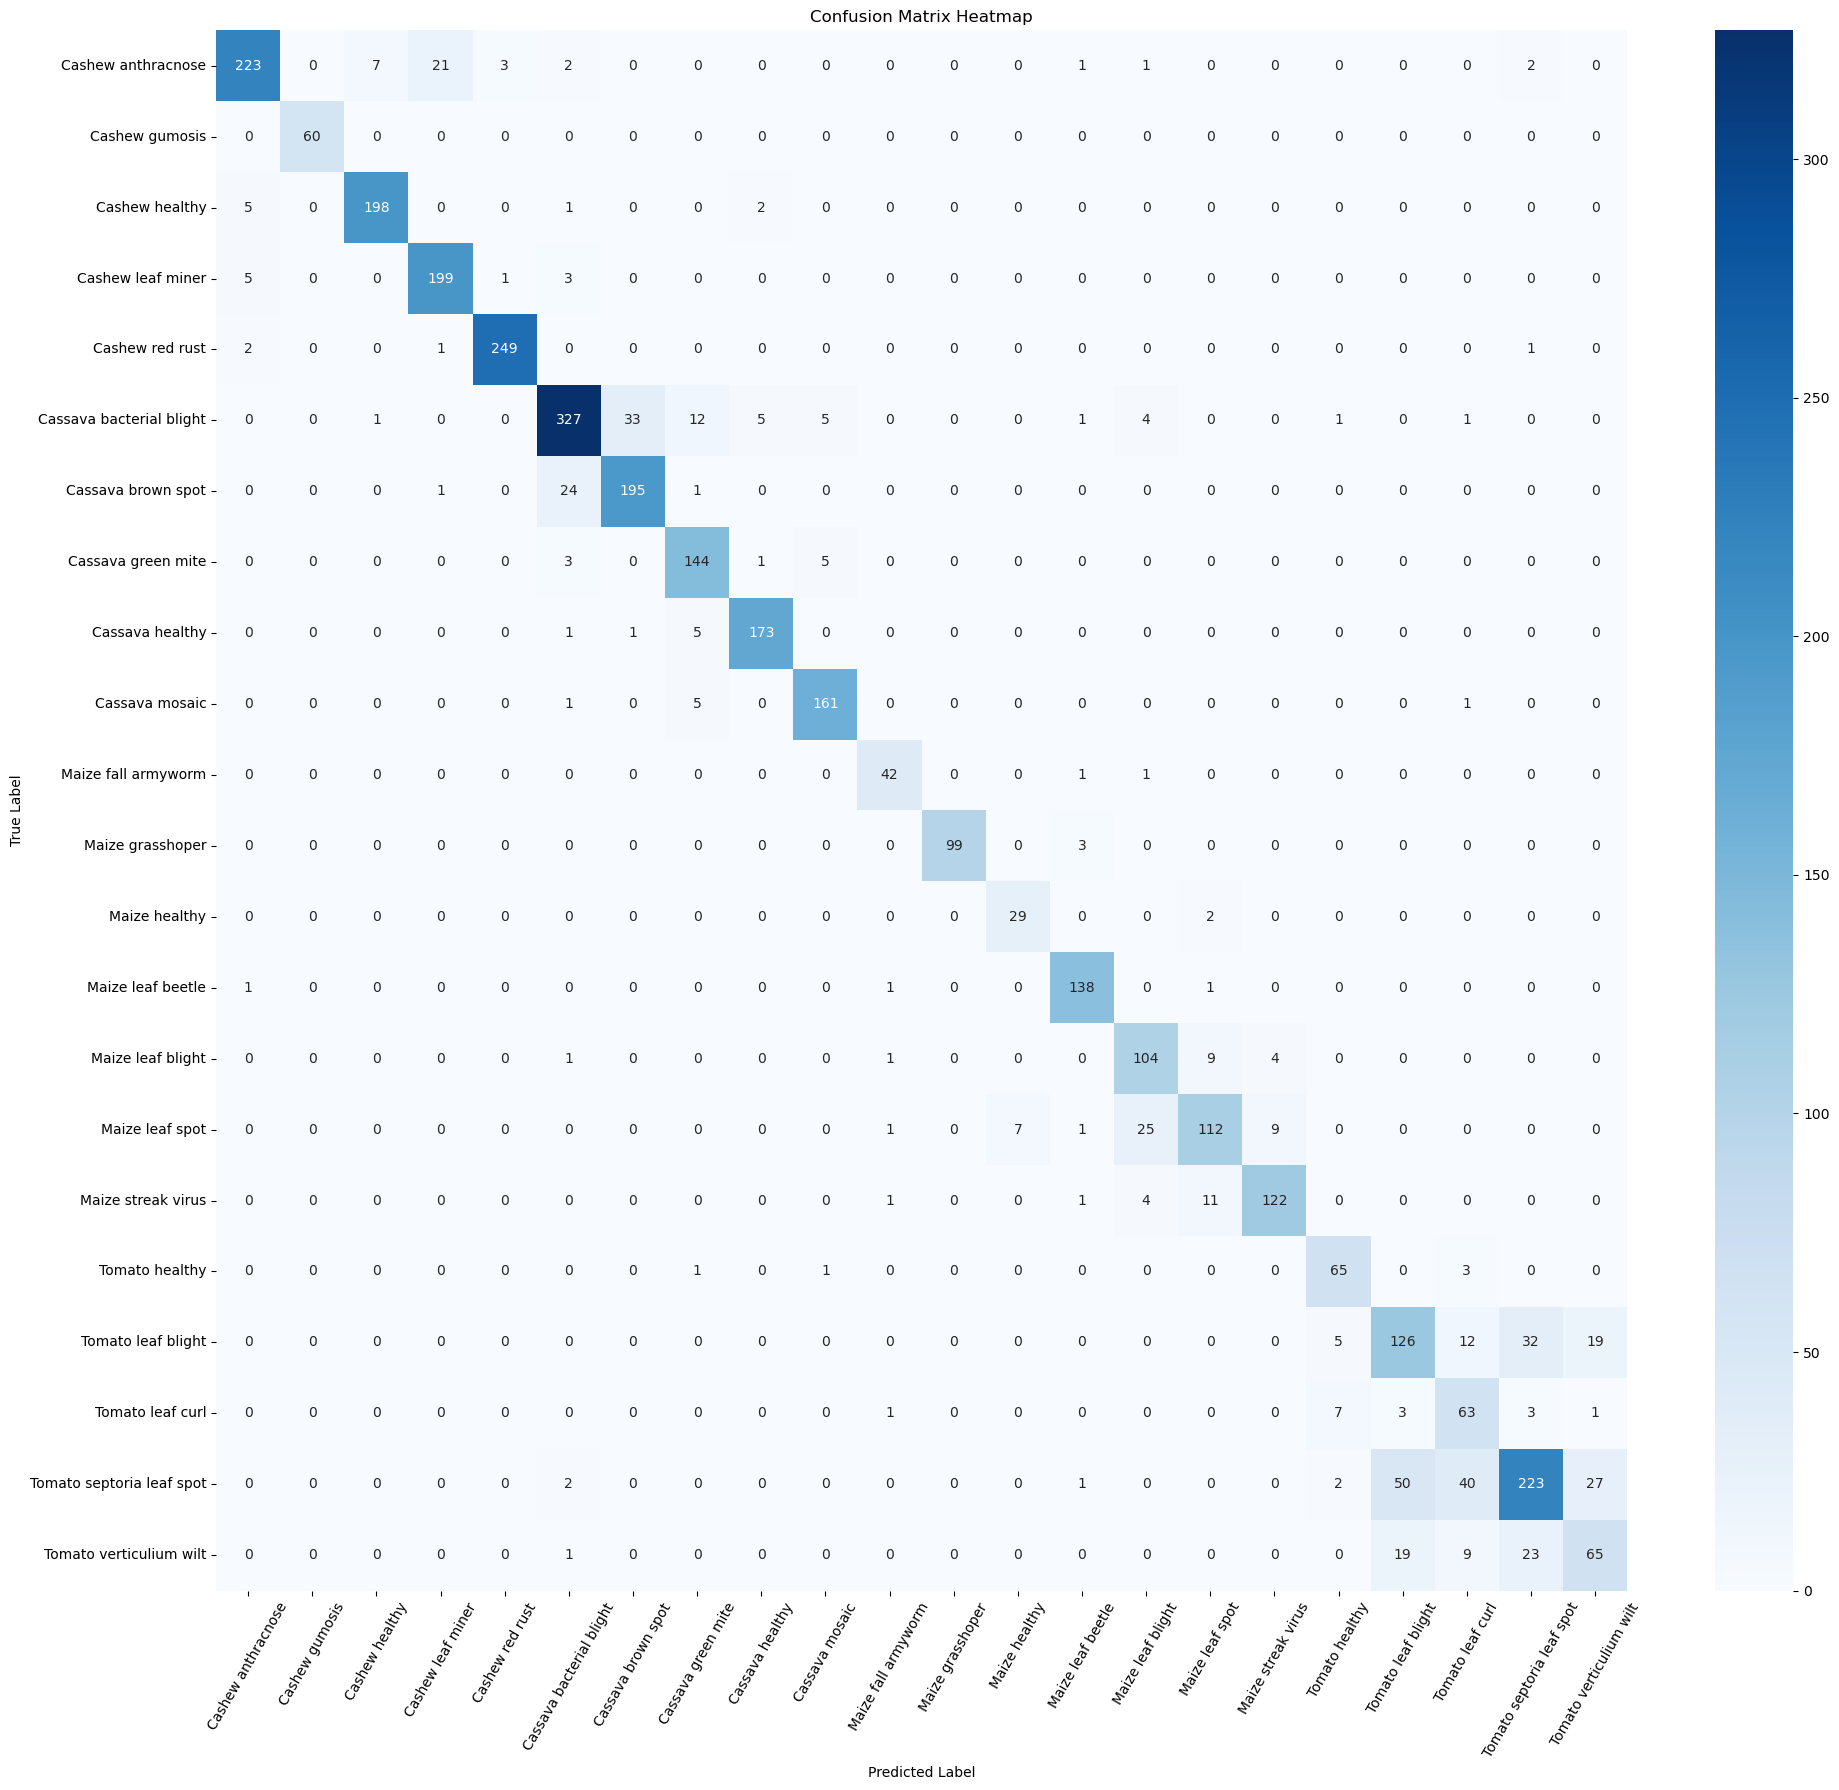

In [50]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 18))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()